# Environment Setup

In [0]:
from pyspark.sql import SparkSession
# Start a new Spark session
spark = SparkSession.builder.appName("YourApp").getOrCreate()

In [0]:
import pyspark
from pyspark import SparkContext 
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, sum, count, when, avg, udf, round

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [0]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
raw = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/mchu@clarku.edu/ad_click_dataset.csv")

# Check the DataFrame
raw.show()

+----+---------+----+----------+-----------+-----------+----------------+-----------+-----+
|  id|full_name| age|    gender|device_type|ad_position|browsing_history|time_of_day|click|
+----+---------+----+----------+-----------+-----------+----------------+-----------+-----+
| 670|  User670|22.0|      null|    Desktop|        Top|        Shopping|  Afternoon|    1|
|3044| User3044|null|      Male|    Desktop|        Top|            null|       null|    1|
|5912| User5912|41.0|Non-Binary|       null|       Side|       Education|      Night|    1|
|5418| User5418|34.0|      Male|       null|       null|   Entertainment|    Evening|    1|
|9452| User9452|39.0|Non-Binary|       null|       null|    Social Media|    Morning|    0|
|5942| User5942|null|Non-Binary|       null|     Bottom|    Social Media|    Evening|    1|
|7808| User7808|26.0|    Female|    Desktop|        Top|            null|       null|    1|
|5065| User5065|40.0|      Male|     Mobile|       Side|            null|    Eve

In [0]:
# Cast 'age' to integer and 'click' to integer (binary)
raw = raw.withColumn("age", col("age").cast("int"))
raw = raw.withColumn("click", col("click").cast("int"))



In [0]:
#encode
#Encode 'gender'
raw = raw.withColumn("gender",
    when(col("gender") == "Male", 1)
    .when(col("gender") == "Female", 2)
    .when(col("gender") == "Non-Binary", 3)
)

# Encode 'device_type'
raw = raw.withColumn("device_type",
    when(col("device_type") == "Mobile", 1)
    .when(col("device_type") == "Desktop", 2)
    .when(col("device_type") == "Tablet", 3)
)

# Encode 'ad_position'
raw = raw.withColumn("ad_position",
when(col("ad_position") == "Top", 1)
    .when(col("ad_position") == "Side", 2)
    .when(col("ad_position") == "Bottom", 3)
)

# Encode 'browsing_history'
raw = raw.withColumn("browsing_history",
    when(col("browsing_history") == "Shopping", 1)
    .when(col("browsing_history") == "News", 2)
    .when(col("browsing_history") == "Entertainment", 3)
    .when(col("browsing_history") == "Education", 4)
    .when(col("browsing_history") == "Social Media", 5)
)

# Encode 'time_of_day'
raw = raw.withColumn("time_of_day",
    when(col("time_of_day") == "Morning", 1)
    .when(col("time_of_day") == "Afternoon", 2)
    .when(col("time_of_day") == "Evening", 3)
    .when(col("time_of_day") == "Night", 4)
)

In [0]:
raw.printSchema()

root
 |-- id: string (nullable = true)
 |-- full_name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- ad_position: integer (nullable = true)
 |-- browsing_history: integer (nullable = true)
 |-- time_of_day: integer (nullable = true)
 |-- click: integer (nullable = true)



# EDA

In [0]:
# Total number of rows in the DataFrame
total_rows = raw.count()
print("total row number:", total_rows)


# Calculate missing value
null_counts = raw.select([sum(col(c).isNull().cast("int")).alias(c) for c in raw.columns])
# Show the result
print("null_count:")
null_counts.show()

# Calculate the percentage of null values in each column
null_percentage = raw.select([(count(when(col(c).isNull(), c)) / total_rows * 100).alias(c) for c in raw.columns])

# Show the result
print("null_percentage:")
null_percentage.show()

total row number: 10000
null_count:
+---+---------+----+------+-----------+-----------+----------------+-----------+-----+
| id|full_name| age|gender|device_type|ad_position|browsing_history|time_of_day|click|
+---+---------+----+------+-----------+-----------+----------------+-----------+-----+
|  0|        0|4766|  4693|       2000|       2000|            4782|       2000|    0|
+---+---------+----+------+-----------+-----------+----------------+-----------+-----+

null_percentage:
+---+---------+------------------+------+-----------+-----------+----------------+-----------+-----+
| id|full_name|               age|gender|device_type|ad_position|browsing_history|time_of_day|click|
+---+---------+------------------+------+-----------+-----------+----------------+-----------+-----+
|0.0|      0.0|47.660000000000004| 46.93|       20.0|       20.0|           47.82|       20.0|  0.0|
+---+---------+------------------+------+-----------+-----------+----------------+-----------+-----+



Missing Data Solution Explain:
I’ve decided to remove the 20% of rows where the ad_position value is missing. This is crucial because ad_position directly influences ad pricing, and having accurate data for this variable is key to my analysis.
My main objective is to identify the most cost-effective ad strategy that generates the highest number of clicks for a general consumer market. Therefore, maintaining reliable data on ad positioning is essential.
For the other missing values:
Numeric columns: I will impute missing values with the average of each column to preserve as much data as possible.
Binary or categorical columns: I will use random imputation based on the original data distribution to ensure the overall balance of categories is maintained.
This approach allows me to focus on the most important factors for the analysis while handling missing data in a way that minimizes bias and preserves data quality.

In [0]:
# clean data
cleaned_position = raw.filter(col("ad_position").isNotNull()) #cleaned null based on position
cleaned_data = cleaned_position.drop("id","full_name")

In [0]:
cleaned_data.drop("id","full_name")

Out[11]: DataFrame[age: int, gender: int, device_type: int, ad_position: int, browsing_history: int, time_of_day: int, click: int]

In [0]:
# seperate data into training and testing, only impute training
train_data, test_data = cleaned_data.randomSplit([0.8, 0.2],seed=123)

In [0]:
#handle imputation for other missing values in train data
#impute age column
avg_age = train_data.select(avg(col("age"))).collect()[0][0] #calculate avg. age
train_data = train_data.fillna({"age": avg_age}) #filled age null value with avg_age

In [0]:
#impute continuous columns that still have null value: gender, device type, browsing history, timeofday
# Step 1: Calculate distributions of non-null values for each categorical column
def calculate_distribution(df, col_name):
    dist_df = df.filter(col(col_name).isNotNull()) \
                .groupBy(col_name) \
                .count() \
                .withColumn('probability', col('count') / sum('count').over(Window.partitionBy()))
    return dist_df

# Step 2: Random assignment based on distribution
import random

def random_assign_missing(df, col_name, dist_df):
    mapping = dist_df.select(col_name, "probability").collect()
    value_probabilities = [(row[col_name], row['probability']) for row in mapping]

    # Define the random choice function to pick values based on the distribution
    def random_choice():
        return random.choices([val[0] for val in value_probabilities], [val[1] for val in value_probabilities])[0]
    
    # Register the random_choice function as a UDF
    random_choice_udf = udf(random_choice)

    # Apply random assignment for missing values in the column
    df = df.withColumn(
        col_name,
        when(col(col_name).isNull(), random_choice_udf()).otherwise(col(col_name))
    )
    
    return df

# Calculate distributions for each categorical column
gender_dist = calculate_distribution(train_data, "gender")
device_type_dist = calculate_distribution(train_data, "device_type")
browsing_history_dist = calculate_distribution(train_data, "browsing_history")
time_of_day_dist = calculate_distribution(train_data, "time_of_day")

# Fill missing values based on distributions
train_data = random_assign_missing(train_data, "gender", gender_dist)
train_data = random_assign_missing(train_data, "device_type", device_type_dist)
train_data = random_assign_missing(train_data, "browsing_history", browsing_history_dist)
train_data = random_assign_missing(train_data, "time_of_day", time_of_day_dist)

In [0]:
categorical_columns = ["gender", "device_type", "browsing_history", "time_of_day"]
for column in categorical_columns:
    train_data = train_data.withColumn(column, col(column).cast("int"))

In [0]:
#round age to whole number because when we input age, we input mostly whole number
train_data = train_data.withColumn("age", round(col("age")))
test_data = test_data.withColumn("age", round(col("age")))

In [0]:
#double check
train_data.show()

+---+------+-----------+-----------+----------------+-----------+-----+
|age|gender|device_type|ad_position|browsing_history|time_of_day|click|
+---+------+-----------+-----------+----------------+-----------+-----+
| 40|     2|          2|          1|               3|          4|    0|
| 40|     1|          1|          1|               3|          4|    0|
| 40|     1|          3|          1|               1|          1|    0|
| 40|     1|          1|          1|               3|          2|    0|
| 40|     3|          3|          1|               2|          1|    1|
| 40|     1|          3|          1|               2|          3|    1|
| 40|     1|          1|          1|               3|          1|    1|
| 40|     3|          1|          1|               5|          1|    1|
| 40|     2|          1|          1|               1|          1|    1|
| 40|     3|          3|          1|               4|          3|    1|
| 40|     3|          3|          1|               3|          1

In [0]:
#descriptive anlaysis
train_data.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              age|            gender|       device_type|       ad_position|  browsing_history|       time_of_day|             click|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             6366|              6366|              6366|              6366|              6366|              6366|              6366|
|   mean|40.08623939679548|1.9844486333647502|1.9828777882500785|2.0364436066603835| 2.986176562990889|2.4748664781652527|0.6542569902607603|
| stddev|9.381314303605103|0.8087755541847399| 0.807382830619883|0.8220780179502329|1.3971570021074278|1.1241460850368883|0.4756472640579388|
|    min|               18|                 1|                 1|                 1|                 1|                 1|                 0|
|    m

In [0]:
# check data type again
train_data.printSchema()


root
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- ad_position: integer (nullable = true)
 |-- browsing_history: integer (nullable = true)
 |-- time_of_day: integer (nullable = true)
 |-- click: integer (nullable = true)



In [0]:
from pyspark.sql import functions as F

#mode value
def calculate_mode(df, col_name):
    mode_df = df.groupBy(col_name).count().orderBy(F.desc("count"))
    mode_value = mode_df.first()  # Get the first row, which is the mode
    return mode_value[col_name]
# List of columns for which to calculate the mode
columns_to_calculate = ["age", "gender", "device_type", "ad_position", "browsing_history", "time_of_day", "click"]

# Dictionary to store the mode results
mode_results = {}

for col in columns_to_calculate:
    mode_results[col] = calculate_mode(train_data, col)

# Display the results
print(mode_results)

{'age': 40, 'gender': 2, 'device_type': 2, 'ad_position': 3, 'browsing_history': 3, 'time_of_day': 1, 'click': 1}


In train_data set (80% rawdata) descriptive analysis, we can tell that mean value is age of 40, female audience(1.9≈2), who use Desktop (1.9≈2), enjoy browsing entertainment page(3.01≈3), position of ad pop up on the side of website they are browsing, and they view ad in afternoon time(2.48≈2), but tend to not click the ads at this moment.
However, there's a bit different in the mode descriptive data, which is the most frequent appeared profile in the dataset, and the result here showing our basic demogrphic are same in gender, age, and device_type, but the ad pops up more in the bottom of webpage, our common audience seems to view ad in the morning, and prefer to have a click more!

In [0]:
# Data Visualization -> use matplotlib
import matplotlib.pyplot as plt

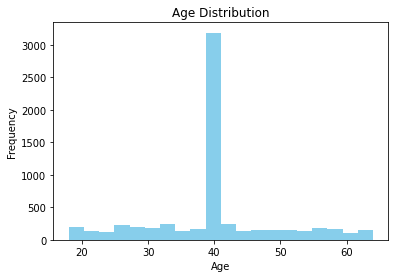

In [0]:
# Age Distribution
plt.hist(train_data.select("age").rdd.flatMap(lambda x: x).collect(), bins=20, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

-> 40 year old respondents seems to be a lots more than other ages, this is because I impute null value with average age in train dataset.

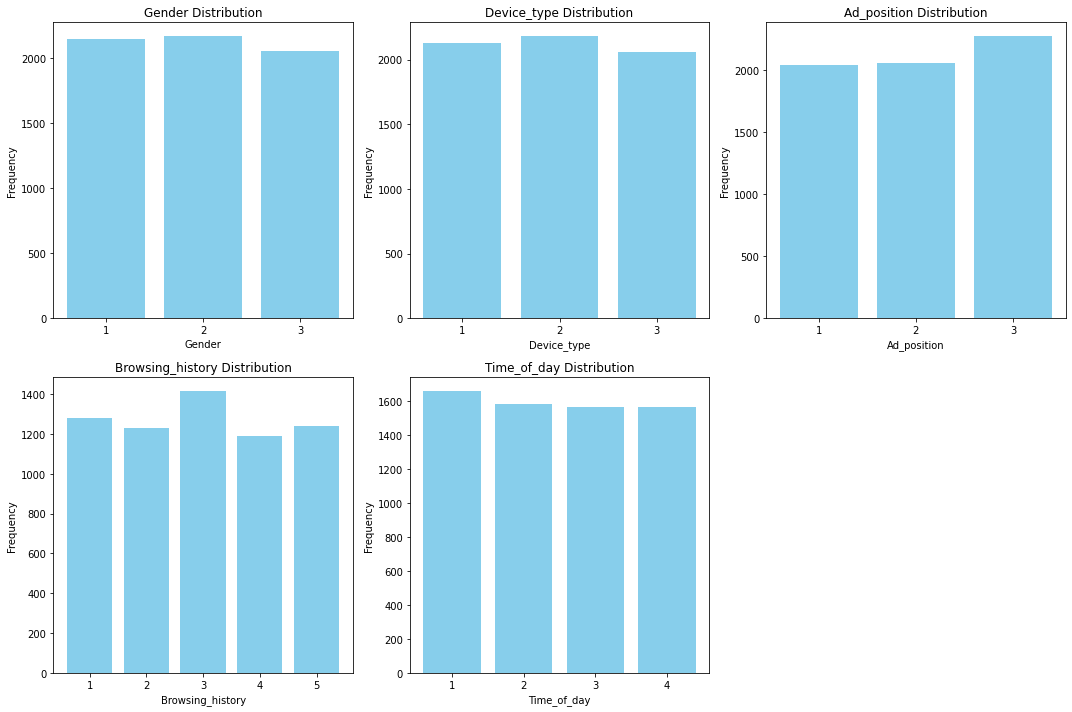

In [0]:
# Define subplot layout
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns; adjust figsize as needed
fig.delaxes(axs[1, 2])  # Remove the last subplot (since we have only 5 graphs)

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Loop through the columns and plot each on a subplot
for i, column in enumerate(["gender", "device_type", "ad_position", "browsing_history", "time_of_day"]):
    values = train_data.groupBy(column).count().orderBy(column).toPandas()
    
    # Create the bar plot in the corresponding subplot
    axs[i].bar(values[column], values['count'], color='skyblue')
    axs[i].set_title(f"{column.capitalize()} Distribution")
    axs[i].set_xlabel(column.capitalize())
    axs[i].set_ylabel("Frequency")

    # Set integer ticks
    axs[i].set_xticks(values[column])  # Ensure ticks are only for unique values
    axs[i].set_xticklabels(values[column].astype(str))  # Convert labels to strings if needed

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

-> distribution in gender, device, ad position, browsing history and time of day seems to be closer to equally distribution and normal distribution is because I impute null value with train dataset distribution of these few columns, so it's more likely to simulatly show the distribution of the non-null value.

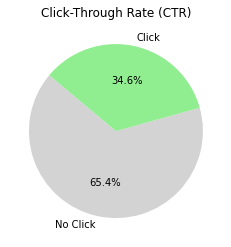

In [0]:
# ad click
click_counts = train_data.groupBy("click").count().toPandas()
plt.pie(click_counts['count'], labels=["No Click", "Click"], autopct='%1.1f%%', startangle=140, colors=['lightgray', 'lightgreen'])
plt.title("Click-Through Rate (CTR)")
plt.show()

-> There's no missing value in ad click column, as a result, this is a 100% real distribution on call to action part. However, according to FaceBook and Google released ad related CTR data, the click rate is not actually this high, so the ad click rate calculation of dataset is more likely to be on certain specific social media such as Twitter or TikTok, etc, compares to more generally Google and Facebook ads.
(support information) The average click-through rate (CTR) for ads varies depending on the type of ad and the platform it appears on:
Search ads: The average CTR for search ads is around 1.91%.
Display ads: The average CTR for display ads is around 0.35%.
Facebook ads: The average CTR for Facebook ads is around 1.11%.
Instagram ads: The average CTR for Instagram ads is around 0.22%.
LinkedIn ads: The average CTR for LinkedIn ads is around 0.22%.
Twitter ads: The average CTR for Twitter ads is around 0.86%.
Social feeds: The average CTR for social feeds is around 1.1–1.3%.

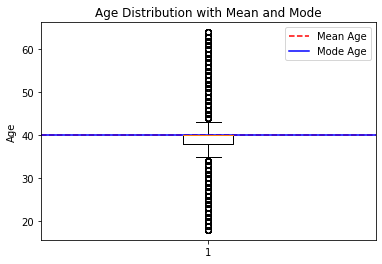

In [0]:
plt.boxplot(train_data.select("age").rdd.flatMap(lambda x: x).collect())
plt.title("Age Distribution with Mean and Mode")
plt.ylabel("Age")
plt.axhline(y=40, color='r', linestyle='--', label="Mean Age")
plt.axhline(y=mode_results["age"], color='b', linestyle='-', label="Mode Age")
plt.legend()
plt.show()


In [0]:
# Calculate mode of 'age' in raw data
# Drop rows where 'age' is null in the raw data
new_raw_data = raw.dropna(subset=["age"])

# Calculate mode of 'age' in the filtered raw data
raw_age_mode = calculate_mode(new_raw_data, "age")
print(raw_age_mode)

# Calculate average of 'age' in the filtered raw data
raw_age_avg = new_raw_data.agg(avg("age")).first()[0]
print(raw_age_avg)

26
40.197363393198316


-> Even though the average age in raw data after dropping null value is 40, but actually the mode age in raw data is just 26, compare to 40 in train data after impute null value, there's a significant difference... but we will testify if this is going to influence accuraccy in prediction model later.

# Model Training

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Create StringIndexers for categorical columns
indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_indexed", handleInvalid="keep") 
    for column in ['gender', 'device_type', 'ad_position']
]

# Create OneHotEncoders
encoders = [
    OneHotEncoder(inputCols=[column+"_indexed" for column in ['gender', 'device_type', 'ad_position']],
                  outputCols=[column+"_encoded" for column in ['gender', 'device_type', 'ad_position']])
]

# Update feature columns to use encoded columns
feature_columns = ['gender_encoded', 'device_type_encoded', 'ad_position_encoded', 
                   'browsing_history', 'time_of_day']

In [0]:
train_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- ad_position: integer (nullable = true)
 |-- browsing_history: integer (nullable = true)
 |-- time_of_day: integer (nullable = true)
 |-- click: integer (nullable = true)



In [0]:
test_data = test_data.na.drop()  # Drop rows with any null values

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Categorical columns to encode
categorical_columns = ['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']

# Create StringIndexers for categorical columns
indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_indexed", handleInvalid="keep") 
    for column in categorical_columns
]

# Create OneHotEncoders for each indexed column
encoders = [
    OneHotEncoder(inputCols=[column+"_indexed"], outputCols=[column+"_encoded"])
    for column in categorical_columns
]

# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline(stages=indexers + encoders)

# Fit the pipeline on training data and transform both datasets
preprocessing_model = preprocessing_pipeline.fit(train_data)
train_preprocessed = preprocessing_model.transform(train_data)
test_preprocessed = preprocessing_model.transform(test_data)

# Convert 'click' to double type (if necessary)
train_preprocessed = train_preprocessed.withColumn("click", col("click").cast(DoubleType()))
test_preprocessed = test_preprocessed.withColumn("click", col("click").cast(DoubleType()))

# Prepare the feature columns: use encoded versions + any numeric columns
encoded_columns = [col+"_encoded" for col in categorical_columns]
numeric_columns = ['age']  # Add other numerical columns if needed
feature_columns = encoded_columns + numeric_columns

# Create VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Assemble features in both datasets
train_features = assembler.transform(train_preprocessed)
test_features = assembler.transform(test_preprocessed)

# Train Decision Tree Model
dt_classifier = DecisionTreeClassifier(labelCol="click", featuresCol="features")
dt_model = dt_classifier.fit(train_features)
dt_predictions = dt_model.transform(test_features)

# Train Gradient Boosted Tree Model
gbt_classifier = GBTClassifier(labelCol="click", featuresCol="features")
gbt_model = gbt_classifier.fit(train_features)
gbt_predictions = gbt_model.transform(test_features)

# Evaluate both models using AUC
evaluator = BinaryClassificationEvaluator(labelCol="click", metricName="areaUnderROC")

dt_auc = evaluator.evaluate(dt_predictions)
print("Decision Tree AUC:", dt_auc)

gbt_auc = evaluator.evaluate(gbt_predictions)
print("Gradient Boosted Tree AUC:", gbt_auc)


Decision Tree AUC: 0.5717787114845939
Gradient Boosted Tree AUC: 0.7253151260504201


In [0]:
test_preprocessed

Out[31]: DataFrame[age: int, gender: int, device_type: int, ad_position: int, browsing_history: int, time_of_day: int, click: double, gender_indexed: double, device_type_indexed: double, ad_position_indexed: double, browsing_history_indexed: double, time_of_day_indexed: double, gender_encoded: vector, device_type_encoded: vector, ad_position_encoded: vector, browsing_history_encoded: vector, time_of_day_encoded: vector]

In [0]:
# Random Forest Classifier
# Create VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Prepare data by assembling features
train_features = assembler.transform(train_preprocessed)
test_features = assembler.transform(test_preprocessed)

# Train Random Forest Model
rf_classifier = RandomForestClassifier(labelCol="click", featuresCol="features")
rf_model = rf_classifier.fit(train_features)
rf_predictions = rf_model.transform(test_features)

# Evaluate Random Forest Model
rf_evaluator = BinaryClassificationEvaluator(labelCol="click")
rf_auc = rf_evaluator.evaluate(rf_predictions)
print("Random Forest AUC:", rf_auc)


Random Forest AUC: 0.6083683473389355


In [0]:
# rf = RandomForestClassifier(featuresCol="features", labelCol="click")
model = rf_classifier.fit(train_features)
importances = model.featureImportances
print("Feature Importances:", importances)


Feature Importances: (19,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],[0.02108657532163067,0.013920007574252135,0.03315746757155159,0.02220047990360938,0.046253447888956606,0.02783302265105395,0.08308462172867279,0.03485000444956983,0.04504958506111734,0.02832588716172899,0.03008616544107432,0.02137873772377708,0.02299750316882898,0.020758191780128863,0.03043936284059786,0.02356182667198994,0.0314968906736017,0.008817654245336702,0.45470256814252147])


Precision: 0.6516129032258065
Recall: 0.9901960784313726
F1-Score: 0.7859922178988327


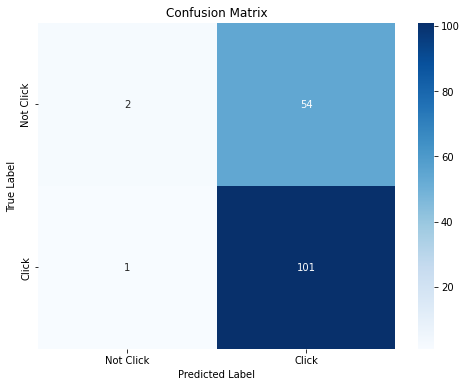

In [0]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
# # Assuming you already have 'train_preprocessed' and 'test_preprocessed' datasets

# # Prepare data by assembling features
# assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
# train_features = assembler.transform(train_preprocessed)
# test_features = assembler.transform(test_preprocessed)

# # Train Random Forest Model
# rf_classifier = RandomForestClassifier(labelCol="click", featuresCol="features")
# rf_model = rf_classifier.fit(train_features)
# rf_predictions = rf_model.transform(test_features)

# # Evaluate AUC using BinaryClassificationEvaluator
# rf_evaluator = BinaryClassificationEvaluator(labelCol="click")
# rf_auc = rf_evaluator.evaluate(rf_predictions)
# print("Random Forest AUC:", rf_auc)

# Calculate precision, recall, and F1 manually
# Extract the prediction and actual labels
predictions_and_labels = rf_predictions.select("prediction", "click")

# Convert to pandas to calculate confusion matrix
predictions_and_labels_pd = predictions_and_labels.toPandas()

# Compute confusion matrix
cm = confusion_matrix(predictions_and_labels_pd['click'], predictions_and_labels_pd['prediction'])
tn, fp, fn, tp = cm.ravel()

# Calculate precision, recall, and F1-score
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Not Click", "Click"], yticklabels=["Not Click", "Click"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [0]:
# train new model with filling random age
train2, test2 = cleaned_data.randomSplit([0.8, 0.2],seed=123)

#impute continuous columns that still have null value: age, gender, device type, browsing history, timeofday

# Calculate distributions for each categorical column
age_dist = calculate_distribution(train2, "age")
gender_dist = calculate_distribution(train2, "gender")
device_type_dist = calculate_distribution(train2, "device_type")
browsing_history_dist = calculate_distribution(train2, "browsing_history")
time_of_day_dist = calculate_distribution(train2, "time_of_day")

# Fill missing values based on distributions
train2 = random_assign_missing(train2, "gender", gender_dist)
train2 = random_assign_missing(train2, "gender", gender_dist)
train2 = random_assign_missing(train2, "device_type", device_type_dist)
train2 = random_assign_missing(train2, "browsing_history", browsing_history_dist)
train2 = random_assign_missing(train2, "time_of_day", time_of_day_dist)

In [0]:
test2 = test2.na.drop()  # Drop rows with any null values

In [0]:
train2.printSchema()

root
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- ad_position: integer (nullable = true)
 |-- browsing_history: string (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- click: integer (nullable = true)



In [0]:
categorical_columns = ["gender", "device_type", "browsing_history", "time_of_day"]
for column in categorical_columns:
    train2_int = train2.withColumn(column, col(column).cast("int"))

In [0]:
# Drop existing indexed columns if they already exist
columns_to_drop = ['gender_indexed', 'device_type_indexed', 'browsing_history_indexed', 'time_of_day_indexed']
train2 = train2.drop(*[col for col in columns_to_drop if col in train2.columns])
test2 = test2.drop(*[col for col in columns_to_drop if col in test2.columns])

# Define StringIndexer for categorical columns
gender_indexer = StringIndexer(inputCol='gender', outputCol='gender_indexed')
device_type_indexer = StringIndexer(inputCol='device_type', outputCol='device_type_indexed')
browsing_history_indexer = StringIndexer(inputCol='browsing_history', outputCol='browsing_history_indexed')
time_of_day_indexer = StringIndexer(inputCol='time_of_day', outputCol='time_of_day_indexed')

# Assemble indexed columns into features
feature_columns = ['gender_indexed', 'device_type_indexed', 'ad_position', 'browsing_history_indexed', 'time_of_day_indexed']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Create and apply the pipeline
pipeline = Pipeline(stages=[gender_indexer, device_type_indexer, browsing_history_indexer, time_of_day_indexer, assembler])
pipeline_model = pipeline.fit(train2)
train2_transformed = pipeline_model.transform(train2)
test2_transformed = pipeline_model.transform(test2)


In [0]:
#from now on, train data is train2_int, and test data is test2 as new version random assign age import data for models

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

stages = []

# Check and add indexers only if the column does not exist
if 'gender_indexed' not in train2.columns:
    stages.append(StringIndexer(inputCol='gender', outputCol='gender_indexed'))
if 'device_type_indexed' not in train2.columns:
    stages.append(StringIndexer(inputCol='device_type', outputCol='device_type_indexed'))
if 'browsing_history_indexed' not in train2.columns:
    stages.append(StringIndexer(inputCol='browsing_history', outputCol='browsing_history_indexed'))
if 'time_of_day_indexed' not in train2.columns:
    stages.append(StringIndexer(inputCol='time_of_day', outputCol='time_of_day_indexed'))

# Assemble indexed columns into features
feature_columns = ['gender_indexed', 'device_type_indexed', 'ad_position', 'browsing_history_indexed', 'time_of_day_indexed']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
stages.append(assembler)

# Apply the pipeline only with the necessary stages
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(train2)
train2_transformed = pipeline_model.transform(train2)
test2_transformed = pipeline_model.transform(test2)


In [0]:
# Train the Random Forest Model
rf_classifier2 = RandomForestClassifier(labelCol="click", featuresCol="features")
rf_model2 = rf_classifier2.fit(train2_transformed)
rf_predictions2 = rf_model2.transform(test2_transformed)

# Evaluate the model with AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
rf_evaluator = BinaryClassificationEvaluator(labelCol="click", metricName="areaUnderROC")
rf_auc2 = rf_evaluator.evaluate(rf_predictions2)
print("Random Forest AUC:", rf_auc2)

Random Forest AUC: 0.5578606442577032


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="click", predictionCol="prediction", metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(rf_predictions2)

# Recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="click", predictionCol="prediction", metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(rf_predictions2)

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="click", predictionCol="prediction", metricName="f1"
)
f1_score = f1_evaluator.evaluate(rf_predictions2)

# Print the metrics
print("Random Forest AUC:", rf_auc2)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Random Forest AUC: 0.5578606442577032
Precision: 0.4167601345938151
Recall: 0.6455696202531646
F1 Score: 0.5065238558909445


# check raw data correlation to find out key variable influence click results


In [0]:
# correlation for raw data
# cleaned_data.display()

In [0]:
# cleaned_corr = cleaned_data.dropna()

In [0]:
# cleaned_corr.display()

In [0]:
# from scipy.stats import chi2_contingency


In [0]:
# from pyspark.sql.functions import corr

# df.select(corr("age", "click")).show()


In [0]:
# from pyspark.ml.classification import LogisticRegression

# # Prepare data
# assembler = VectorAssembler(inputCols=["age", "gender", "device_type", "ad_position", "time_of_day"], outputCol="features")
# df_transformed = assembler.transform(df).select('features', 'click')

# # Train model
# lr = LogisticRegression(labelCol='click')
# model = lr.fit(df_transformed)

# # Evaluate
# summary = model.summary
# summary.roc.show()


In [0]:
no_click = cleaned_data.select('click').where(cleaned_data.click == 0).count()
yes_click = cleaned_data.select('click').where(cleaned_data.click == 1).count()

print(no_click)
print(yes_click)


2782
5218
